In [1]:
cd /home/nico/richai/

/home/nico/richai


In [2]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    recall_score
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob

# Plotting utils

In [3]:
target_names = ["muon", "pion"]

In [4]:
def wrangle_predictions(df, width=1):
    """Wrangle model predictions for plotting.

    Parameters
    ----------
    df : pandas DataFrame
        Initial data from model predictions (output of `get_predictions`)
    width : int, optional
        Width of momentum bins to add to data, by default 1

    Returns
    -------
    wrangled_df
        Wrangled data for plotting.
    """
    df = df.copy()
    bins = []
    bin_labels = []

    # generate bins and bin labels for momentum
    for i in range(0, 40 + width, width):
        bins.append(i)
        bin_labels.append(f"({i}, {i+width}]")

    bins.append(np.inf)
    bin_labels.pop()
    bin_labels.append("40+")

    # add momentum bins to results
    df["momentum_bin"] = pd.cut(x=df["momentum"], bins=bins, labels=bin_labels)

    # pion efficiency by momentum bin (pion recall)
    pion_effciency = df.groupby("momentum_bin").apply(
        lambda x: recall_score(
            x["labels"], x["predictions"], zero_division=0, pos_label=1
        )
    )

    # muon efficiency by momentum bin (1 - muon recall)
    muon_efficiency = 1 - (
        df.groupby("momentum_bin").apply(
            lambda x: recall_score(
                x["labels"], x["predictions"], zero_division=0, pos_label=0
            )
        )
    )

    # combine pion/muon efficiency into one df
    efficiency_df = pd.concat([pion_effciency, muon_efficiency], axis=1)

    efficiency_df.columns = ["pion_efficiency", "muon_efficiency"]

    # counts of actual/predicted muons/pions by momentum bin
    labels_df = df.groupby(["momentum_bin", "labels"]).size().unstack(fill_value=0)
    predictions_df = (
        df.groupby(["momentum_bin", "predictions"]).size().unstack(fill_value=0)
    )

    labels_df.columns = ["actual_muons", "actual_pions"]
    predictions_df.columns = ["predicted_muons", "predicted_pions"]

    # combine efficiency df with counts dfs
    wrangled_df = pd.concat([efficiency_df, labels_df, predictions_df], axis=1)
    wrangled_df = wrangled_df.query("actual_muons + actual_pions != 0")

    return wrangled_df

In [5]:
def plot_cm(
    y_true, y_pred, target_names=["muon", "pion"], normalize="true", title=None
):
    """Plot a confusion matrix for a classifier.

    Parameters
    ----------
    y_true : pandas Series
        The actual label values.
    y_pred : pandas Series
        The predicted label values.
    target_names : list of str, by default ["muon", "pion"]
        The class labels
    normalize : str, optional
        Whether or not to normalize the CM, by default "true"
    title : str, optional
        Plot title, by default None
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(ax=ax, cmap="cividis", values_format=".4f")

    ax.set_ylabel("Actual class", fontsize=18)
    ax.set_xlabel("Predicted class", fontsize=18)
    plt.setp(ax.get_xticklabels(), fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)

    if title:
        plt.suptitle(title, y=0.92, fontsize=20)

    for labels in disp.text_.ravel():
        labels.set_fontsize(15)

    plt.show()


def show_results(path):
    """Show the classification report and confusion matrix for a classifier.

    Parameters
    ----------
    path : str
        The path to the model results .csv file.
    """
    results = pd.read_csv(path)
    target_names = ["muon", "pion"]

    # classification report
    print(
        classification_report(
            y_true=results["labels"],
            y_pred=results["predictions"],
            target_names=target_names,
        )
    )

    # confusion matrix
    plot_cm(
        y_true=results["labels"],
        y_pred=results["predictions"],
        target_names=target_names,
    )


def plot_roc_curves(models, title, op_point=None):
    """Plot ROC curves for multiple models.

    Parameters
    ----------
    models : dict
        Dictionary where the key: values are "name: model path".
        "name" will be shown in the legend of the plot for that model.
        "model path" is the file path to the csv results for that model.
    title : str
        Plot titile.
    op_point : float, optional
        The operating point to plot on the ROC curve, by default None.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # iterate through models and plot ROC curve for each
    for name, path in models.items():
        df = pd.read_csv(path)

        fpr, tpr, thresholds = roc_curve(
            y_true=df["labels"],
            y_score=df["probabilities"],
        )

        # optionally plot operating points
        if op_point is not None:
            op_point_loc = np.argmin(np.abs(thresholds - op_point))
            ax.plot(fpr[op_point_loc], tpr[op_point_loc], "o", markersize=8, c="r")

        # plot roc curve
        disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=name)
        disp.plot(ax=ax)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel("False Positive Rate (Muon/Pion)", fontsize=16)
    ax.set_ylabel("True Positive Rate (Pion/Pion)", fontsize=16)

    # 45 degree line is equivalent of a random classifier
    ax.plot([0, 1], [0, 1], color="black", linestyle="--")

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(16)

    plt.show()


def plot_efficiencies(results_df, title=None):
    """Plot pion and muon efficiencies by momentum bin.

    Parameters
    ----------
    results_df : pandas DataFrame
        Prediction data containing momentum bins and efficiencies.
    title : str, optional
        Overall title for the plot.
    """
    fig, ax1 = plt.subplots(figsize=(9, 7))

    # global plot variables
    pion_color = "black"  # pion plotting color
    muon_color = "blue"  # muon plotting color
    label_fs = 17  # axis label font size
    tick_fs = 13  # axis tick font size
    major_length, major_width = 7, 2  # major axis tick sizes
    minor_length, minor_width = 4, 1  # minor axis tick sizes
    main_ms, line_ms = 7, 9  # circle/square/line marker sizes
    labelpad = 10  # padding for axis labels

    # plot pion efficiency as circles with horizontal lines
    results_df["pion_efficiency"].plot(
        ax=ax1, color=pion_color, style="o", markersize=main_ms
    )
    results_df["pion_efficiency"].plot(
        ax=ax1, marker=0, linestyle="", markersize=line_ms, color=pion_color
    )
    results_df["pion_efficiency"].plot(
        ax=ax1, marker=1, linestyle="", markersize=line_ms, color=pion_color
    )

    # momentum x-axis customization (shared axis)
    ax1.set_xlabel(
        "Particle momentum [GeV/c]",
        fontsize=label_fs,
        fontweight="bold",
        labelpad=labelpad,
    )
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.grid(True, linestyle="--")

    for label in ax1.get_xticklabels():
        label.set_fontweight("bold")

    # pion y-axis customization
    ax1.set_ylim(0.7)
    ax1.set_ylabel(
        "Pion efficiency",
        color=pion_color,
        fontsize=label_fs,
        fontweight="bold",
        labelpad=labelpad,
    )
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    ax1.tick_params(
        which="major", length=major_length, width=major_width, labelsize=tick_fs
    )
    ax1.tick_params(which="minor", length=minor_length, width=minor_width)

    for label in ax1.get_yticklabels():
        label.set_fontweight("bold")

    # second x-axis for muon
    ax2 = ax1.twinx()

    # plot muon efficiency as squares with horizontal lines
    results_df["muon_efficiency"].plot(
        ax=ax2, color=muon_color, style="s", markersize=main_ms
    )
    results_df["muon_efficiency"].plot(
        ax=ax2, marker=0, linestyle="", markersize=line_ms, color=muon_color
    )
    results_df["muon_efficiency"].plot(
        ax=ax2, marker=1, linestyle="", markersize=line_ms, color=muon_color
    )

    # muon x-axis customization
    ax2.set_ylim(0, 0.3)
    ax2.set_ylabel(
        "Muon efficiency",
        color=muon_color,
        fontsize=label_fs,
        fontweight="bold",
        labelpad=labelpad,
    )
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    ax2.tick_params(
        which="major", length=major_length, width=major_width, labelsize=tick_fs
    )
    ax2.tick_params(which="minor", length=minor_length, width=minor_width)
    ax2.tick_params(which="both", color=muon_color, labelcolor=muon_color)

    for label in ax2.get_yticklabels():
        label.set_fontweight("bold")

    if title:
        plt.suptitle(title, fontsize=20, y=0.94)

    plt.show()


# Model results

## Dynamic Graph CNN v1

- $\text{Epochs} = 4$
- $k = 8$
- $\delta = 0.15$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

In [6]:
# show_results("saved_models/validation_results/dgcnn_k8_delta015_results.csv")

## Dynamic Graph CNN v2

- $\text{Epochs} = 4$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

In [7]:
# show_results("saved_models/validation_results/dgcnn_k8_delta030_results.csv")

## Dynamic Graph CNN v3

- $\text{Epochs} = 4$
- $k = 16$
- $\delta = 0.15$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

In [8]:
# show_results("saved_models/validation_results/dgcnn_k16_delta015_results.csv")

## Dynamic Graph CNN v4

- $\text{Epochs} = 4$
- $k = 16$
- $\delta = 0.30$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

In [9]:
# show_results("saved_models/validation_results/dgcnn_k16_delta030_results.csv")

## Dynamic Graph CNN v5

- $\text{Epochs} = 4 \text{ and } 8$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{True}$
- $\text{Radius} = \text{False}$

#### After 4 epochs

In [10]:
# show_results("saved_models/validation_results/dgcnn_k8_delta030_momentum_4epochs.csv")

#### After 8 epochs

In [11]:
# show_results("saved_models/validation_results/dgcnn_k8_delta030_momentum_8epochs.csv")

## Dynamic Graph CNN v6

- $\text{Epochs} = 4 \text{ and } 8$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{True}$
- $\text{Radius} = \text{True}$

#### After 4 epochs

In [12]:
# show_results("saved_models/validation_results/dgcnn_k8_delta030_momentum_radius_4epochs.csv")

#### After 8 epochs

In [13]:
# show_results("saved_models/validation_results/dgcnn_k8_delta030_momentum_radius_8epochs.csv")

# Prediction data for plotting

In [14]:
# this is good enough for CM and ROC curves
df = pd.read_csv('saved_models/validation_results/dgcnn_k8_delta075_momentum_radius_4epochs.csv')
df.head()

,labels,predictions,probabilities,momentum
0,0,0,0.012341,24.360786
1,0,0,0.409467,31.973522
2,1,1,0.873815,26.785885
3,0,0,0.019306,16.357674
4,0,0,0.070634,32.495796


In [15]:
# we need to wrangle for efficiency plots
wrangled_df = wrangle_predictions(df)
wrangled_df.head()

,pion_efficiency,muon_efficiency,actual_muons,actual_pions,predicted_muons,predicted_pions
momentum_bin,,,,,,
"(15, 16]",1.000000,0.016260,615,383,605,393
"(16, 17]",0.998175,0.010622,659,548,653,554
"(17, 18]",0.994048,0.002797,715,672,717,670
"(18, 19]",0.987578,0.002415,828,805,836,797
"(19, 20]",0.992135,0.005336,937,890,939,888


## ROC Curves

### Momentum models

In [16]:
momentum_model_paths = glob.glob("saved_models/validation_results/**_momentum_[0-9]**")
momentum_model_paths.sort()
momentum_names = [path.split("/")[-1][6:-4] for path in momentum_model_paths]
momentum_models = {name:path for name, path in zip(momentum_names, momentum_model_paths)}
momentum_models

{'k8_delta030_momentum_4epochs': 'saved_models/validation_results/dgcnn_k8_delta030_momentum_4epochs.csv',
 'k8_delta030_momentum_8epochs': 'saved_models/validation_results/dgcnn_k8_delta030_momentum_8epochs.csv',
 'k8_delta040_momentum_4epochs': 'saved_models/validation_results/dgcnn_k8_delta040_momentum_4epochs.csv',
 'k8_delta050_momentum_4epochs': 'saved_models/validation_results/dgcnn_k8_delta050_momentum_4epochs.csv'}

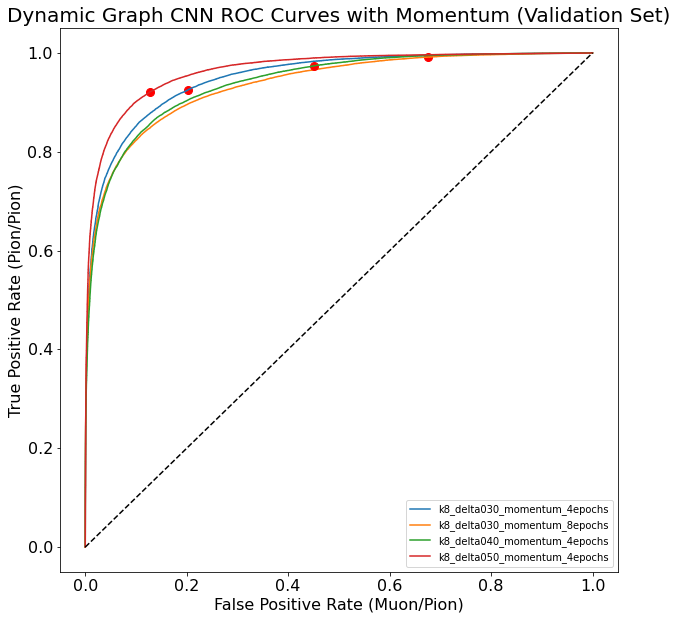

In [17]:
plot_roc_curves(
    momentum_models,
    title="Dynamic Graph CNN ROC Curves with Momentum (Validation Set)",
    op_point=0.5
)

### Momentum and radius models

In [18]:
radius_model_paths = glob.glob("saved_models/validation_results/**_momentum_radius_**")
radius_model_paths.sort()
radius_names = [path.split("/")[-1][6:-4] for path in radius_model_paths]
radius_models = {name:path for name, path in zip(radius_names, radius_model_paths)}
radius_models

{'k8_delta030_momentum_radius_4epochs': 'saved_models/validation_results/dgcnn_k8_delta030_momentum_radius_4epochs.csv',
 'k8_delta030_momentum_radius_8epochs': 'saved_models/validation_results/dgcnn_k8_delta030_momentum_radius_8epochs.csv',
 'k8_delta040_momentum_radius_4epochs': 'saved_models/validation_results/dgcnn_k8_delta040_momentum_radius_4epochs.csv',
 'k8_delta050_momentum_radius_4epochs': 'saved_models/validation_results/dgcnn_k8_delta050_momentum_radius_4epochs.csv',
 'k8_delta075_momentum_radius_4epochs': 'saved_models/validation_results/dgcnn_k8_delta075_momentum_radius_4epochs.csv'}

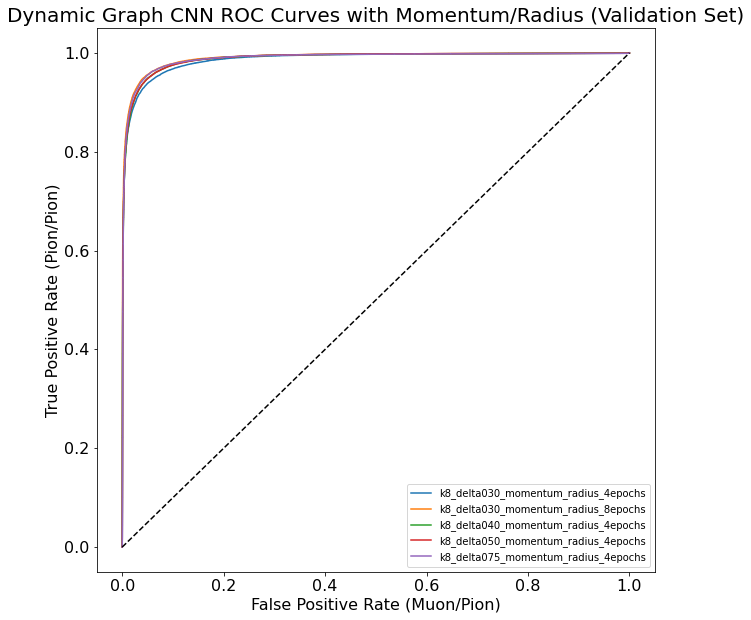

In [19]:
plot_roc_curves(
    radius_models,
    title="Dynamic Graph CNN ROC Curves with Momentum/Radius (Validation Set)",
#     op_point=0.5
)

# Pion vs. Muon Effciency

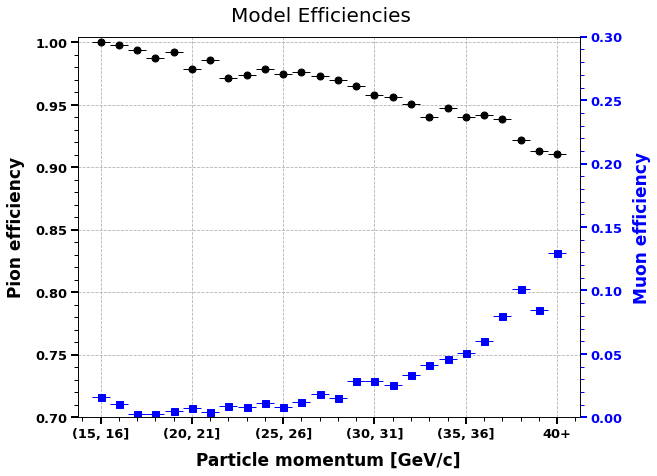

In [20]:
plot_efficiencies(wrangled_df, "Model Efficiencies")